## Верхний предел на $Br ( f_2^{'}(1525) \to e^+ e^- )$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
from pylib.statistics import efficiency_error
from pylib.preprocess import HandlerKSKS
from pylib.radcors import RadCor
import pylib.fit as pyfit
import pylib.ksks as ksks
import iminuit
import seaborn as sns
import awkward as ak

from progressbar import progressbar
import re

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

# Born $\to$ visible cross sections

In [3]:
def born2visible(e_beams : np.array, 
                 cs_born : np.array, threshold: float) -> np.array:
    """
    Видимые сечения из борновских
    e_beams - энергии пучка (МэВ),
    cs_born - борновские сечения (нбн),
    threshold - порог рождения (МэВ)
    """
    rc = RadCor(e_beams, cs_born, threshold)
    radcors = []
    for e_beam in e_beams:
        radcors.append(
            rc.F_Radcor(e_beam, [], use_efficiency=False)[0]
        )
    return cs_born*radcors

## Видимое сечение $e^+e^- \to \ f \ \to \ K_SK_S$

$$
    \sigma_{born}(s) = \frac{20 \pi}{s} \frac{M_f^2 \Gamma^2 Br(f \to e^+e^-) Br(f \to K \overline{K})}{{(M_f^2 - s)}^2 + M_f^2 \Gamma^2}
$$

$$
    Br(f \to e^+ e^-)_U = \frac{4}{9} \alpha^2 Br(f \to \gamma \gamma)
$$

в унитарном пределе (взял из диплома формулы)

In [4]:
Br_ee_unitary_limit = (4/9)*( ((1/137.04)**2) * 9.5e-7)

def born_ee_f(s, M = 1517.4, W = 86, Br_ee = Br_ee_unitary_limit, Br_f = 0.876):
    """
    Борновское сечение процесса e+e- -> T -> f (нбн), 
    T - тензорный резонанс, f - конечное состояние
    M - массса резонанса (МэВ/c), W - ширина резонанса (МэВ/c),
    s - ГэВ^2
    """
    s_MeV = s*1e6
    breit_wigner = (M**2)*(W**2)*Br_ee*Br_f/( (M**2 - s_MeV)**2 + (M**2)*(W**2) )
    norm_constant = 0.38938e6 # GeV^2 * nbn
    cs_born = (20*np.pi/s)*breit_wigner*norm_constant
    return cs_born # nbn

In [5]:
df_fksks = pd.DataFrame({'ebeam': np.linspace(550, 950, 250)})
df_fksks['cs_born'] = born_ee_f((df_fksks['ebeam']*2e-3)**2)

In [6]:
df_fksks['cs_vis'] = born2visible(df_fksks['ebeam'], 
                                  df_fksks['cs_born'],
                                 threshold=497.6)

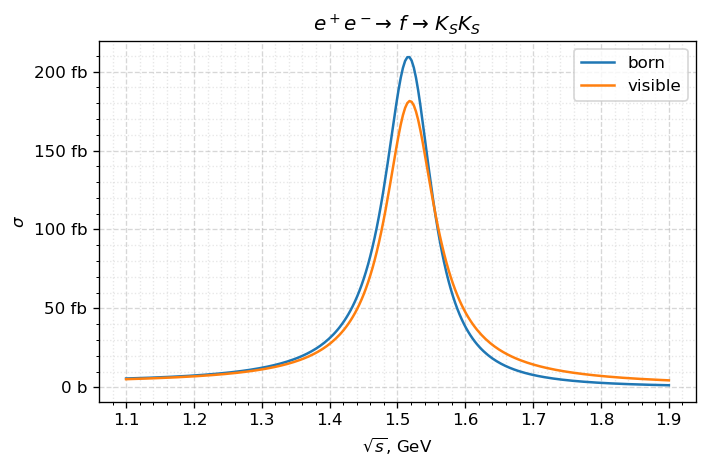

In [7]:
from matplotlib.ticker import EngFormatter

plt.plot(df_fksks['ebeam']*2e-3, df_fksks['cs_born']*1e-9, label='born')
plt.plot(df_fksks['ebeam']*2e-3, df_fksks['cs_vis']*1e-9, label='visible')
formatter0 = EngFormatter(unit='b')
plt.gca().yaxis.set_major_formatter(formatter0)
pys.my_style(r'$e^+e^- \to \ f \ \to \ K_SK_S$', 
             '$\sqrt{s}$, GeV', '$\\sigma$', legend=True);

## Видимое сечение $e^+e^- \ \to \ 2 \pi^+ 2\pi^-$

поскольку основной фон $2 \pi^+ 2\pi^-$, то его надо вычитать и знать сечения

борновские сечения взял из `cmd3sim` (насколько я понял, там результаты BaBar)

In [8]:
df_4pic = pd.read_csv('../csv/ksks/cs_born_4pic.csv', 
                      sep=' ', header=None, index_col=0)
df_4pic[1] /=2
df_4pic.columns = ['ebeam', 'cs_born']
df_4pic = df_4pic.query('(ebeam<950)')

In [9]:
df_4pic['cs_vis'] = born2visible(df_4pic['ebeam'].values, 
                                 df_4pic['cs_born'].values, 
                                 threshold=139.57*2)

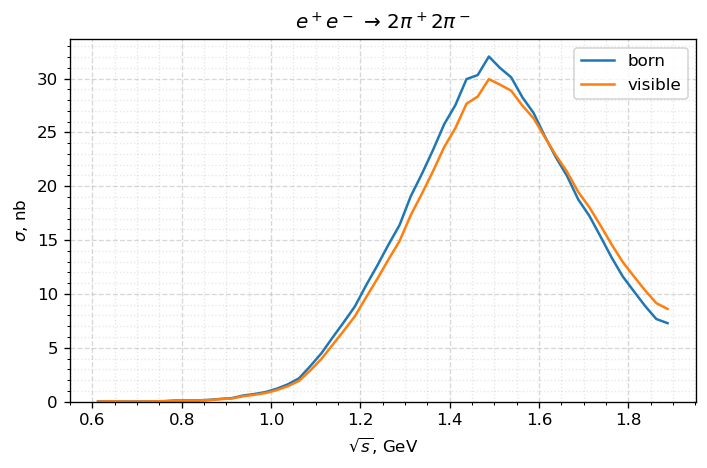

In [10]:
plt.plot(df_4pic['ebeam']*2e-3, df_4pic['cs_born'], label='born');
plt.plot(df_4pic['ebeam']*2e-3, df_4pic['cs_vis'], label='visible');
pys.my_style(r'$e^+e^- \ \to \ 2 \pi^+ 2\pi^-$', 
             '$\sqrt{s}$, GeV', '$\sigma$, nb', 
             ylim=(0,None), legend=True)

# MC analysis

Проанализирую распределения в Монте-Карло $e^+ e^- \to f \to K_S K_S$

In [11]:
# tr_mc = uproot.open('/outstage/lukinp/sim/tr_ph_f2ksks_1.8GeV.root')['tr_ph']
tr_mc = uproot.open('/outstage/lukinp/sim/tr_ph_run062256.root')['tr_ph']

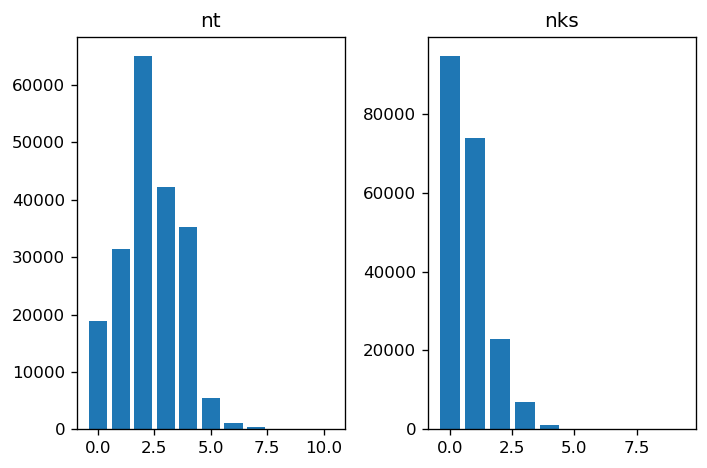

In [12]:
data_mc = tr_mc.arrays(['nt', 'nks'], library='np')
fig, ax = plt.subplots(1, 2)
t_mc, nt_mc = np.unique(data_mc['nt'], return_counts=True)
ax[0].bar(t_mc, nt_mc)
ax[0].set(title='nt')
t_mc, nt_mc = np.unique(data_mc['nks'], return_counts=True)
ax[1].bar(t_mc, nt_mc)
ax[1].set(title='nks')
plt.tight_layout()

у меня условие отбора `nt>=4` и `nks==2`, так что сразу можно ожидать низкую эффективность

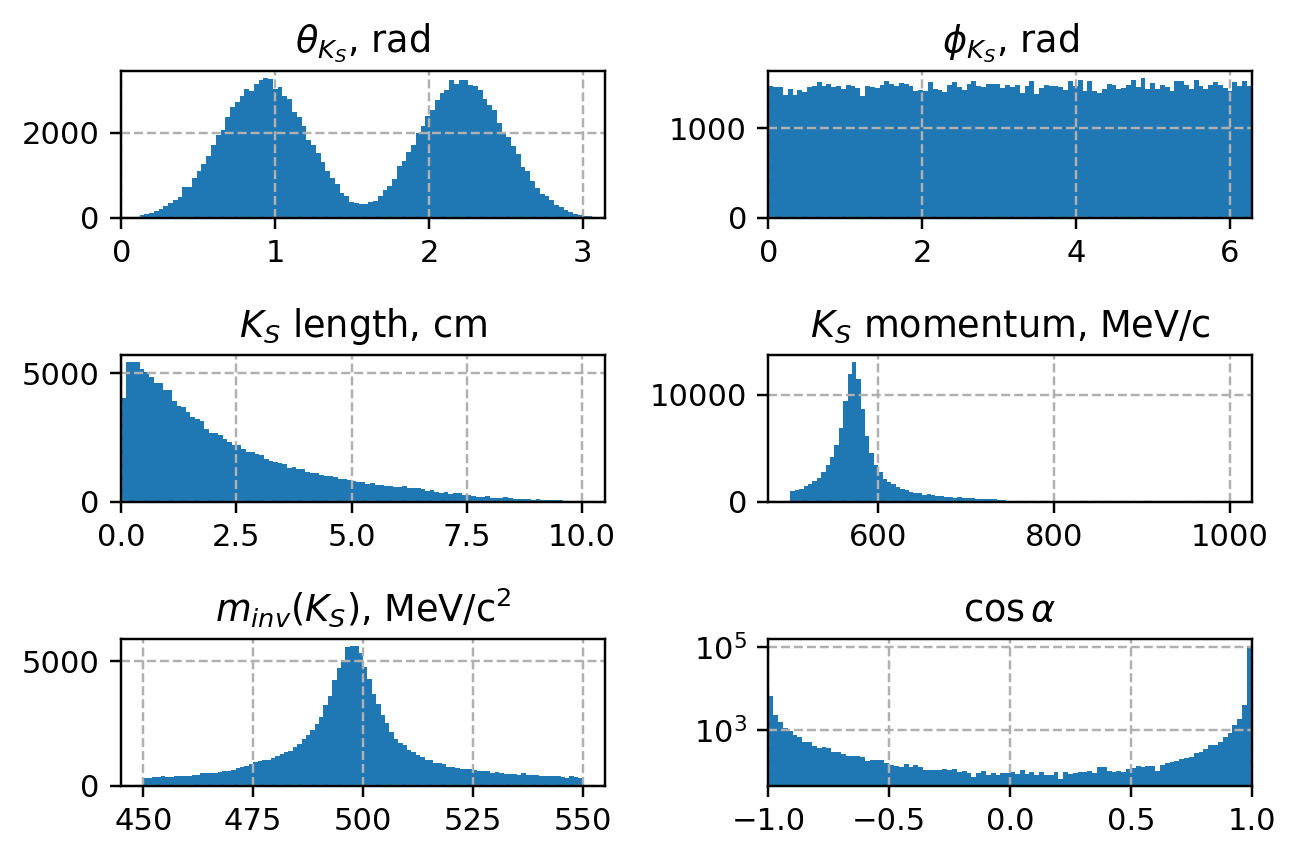

In [13]:
temp = tr_mc.arrays(['ksth', 'ksphi', 'ksptot', 'ksminv', 'ksalign',
                    'kslen', 'nks'], library='pd')#.query('nks==2')
fig, ax = plt.subplots(3, 2, dpi=220)
ax = ax.flatten()
for a in ax:
    a.grid(ls='--')
ax[0].hist(temp.ksth, bins=100);
ax[0].set(title=r'$\theta_{K_S}$, rad', xlim=(0, np.pi))
ax[1].hist(temp.ksphi, bins=100);
ax[1].set(title=r'$\phi_{K_S}$, rad', xlim=(0, 2*np.pi))
ax[2].hist(temp.kslen, bins=100, range=(0, 10));
ax[2].set(title=r'$K_S$ length, cm', xlim=(0, None))
ax[3].hist(temp.ksptot, bins=100, range=(500, 1000));
ax[3].set(title=r'$K_S$ momentum, MeV/c')
ax[4].hist(temp.ksminv, bins=100, range=(450, 550));
ax[4].set(title=r'$m_{inv}(K_S)$, MeV/c${}^2$')
ax[5].hist(temp.ksalign, bins=100);
ax[5].set(title=r'$\cos{\alpha}$', xlim=(-1, 1), yscale='log')
plt.tight_layout()

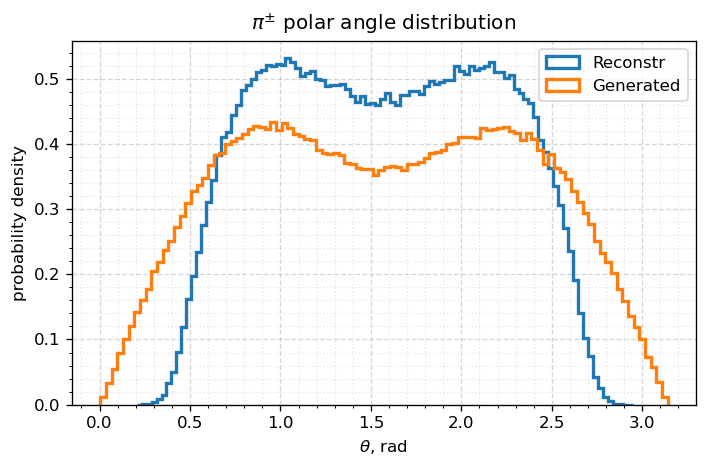

In [14]:
temp =tr_mc.arrays(['simtheta'], cut='abs(simtype)==211', library='pd').simtheta
temp1 = tr_mc.arrays(['tth'], library='pd')
plt.hist(temp1, bins=100, density=True, histtype='step', lw=2, label='Reconstr');
plt.hist(temp, bins=100, density=True, histtype='step', lw=2, label='Generated');
pys.my_style('$\pi^{\pm}$ polar angle distribution', 
             r'$\theta$, rad', 'probability density', legend=True)

In [15]:
# dtemp = tr_mc.arrays(['ksalign'], cut='kslen>0.1', library='pd')
# temp_eff = len(dtemp.query('ksalign>0.8'))/len(dtemp)
# print(f'{temp_eff:.2%}')

## Объясняю эффективность

In [16]:
tr_mc.arrays(['simtype'], 'simorig==310', library='pd').\
value_counts().head(12)

simtype    
 211           276611
-211           276606
 111           246174
 22               828
 2112             606
 2212             485
 1000020040       105
 310               96
 130               93
 321               60
 3122              50
 1000010020        48
dtype: int64

вот такие частицы есть в моделировании, 

из интересного, `1000020040`, например, $\alpha$-частица (список [здесь](https://twiki.cern.ch/twiki/pub/Geant4/ExtendingFnalDb/Nuclei.txt))

In [17]:
temp_type = tr_mc.arrays(['simtype'], 'simorig==310', library='pd')
temp_type['is_pic'] = ( np.abs(temp_type['simtype']) == 211 )

n_pic = temp_type.groupby('entry').agg({'is_pic' : 'sum'})
gt_idx = n_pic.query('is_pic==4').index
n_pic = n_pic.value_counts()
n_pic.head()

is_pic
4         95619
2         85302
0         19022
3            40
1            17
dtype: int64

In [18]:
eff_kppc = (n_pic.loc[4]/n_pic.sum()).values[0]
print(f"""Доля событий, где оба каона распались на заряженные пионы: \
{eff_kppc:.2%} \
""")

Доля событий, где оба каона распались на заряженные пионы: 47.81% 


эффективность, обусловленная физическими распадами закончилась, теперь о том, какова *эффективность восстановления трека*:

в событиях, где оба $K_S$ распались на $\pi^+\pi^-$ смотрим, какой процент треков реконструировался

In [19]:
nt_mc = tr_mc.arrays(['nt'], library='pd').loc[gt_idx]
eff_1t = nt_mc.sum().item()/(len(nt_mc)*4)
print(f"""Эффективность восстановления трека: {eff_1t:.2%}""")

Эффективность восстановления трека: 82.33%


у нас должно восстановиться 4 трека (возводим эту эффективность в 4-ю степень)

In [20]:
eff_4t = eff_1t**4
print(f"""Эффективность восстановления 4 треков: {eff_4t:.2%}""")

Эффективность восстановления 4 треков: 45.96%


тогда общая эффективность:

In [21]:
print(f'{eff_kppc * eff_4t:.2%}')

21.97%


Теперь смотрим *эффективность восстановления $K_S$ процедурой*, если у нас есть пара треков

В $e^+e^- \to K_S K_S$ два $K_S$

In [22]:
tt = tr_mc.arrays(['nks', 'nt'], library='pd')
eff_2ks = tt.query('(nt==4)&(nks==2)').index.nunique()/tt.query('nt==4').index.nunique()

In [23]:
# gt_idx2 = nt_mc.query('nt==4').index
# nks_mc = tr_mc.arrays(['nks'], library='pd').loc[gt_idx2].nks.sum().item()
# nks_mc_total = gt_idx2.nunique()*2
# print(f'Эффективность восстановления KS: {nks_mc/nks_mc_total:.2%}')

In [24]:
# eff_2ks = (nks_mc/nks_mc_total)**2
print(f'Эффективность восстановления двух KS: {eff_2ks:.2%} (в событиях, где найдено 4 трека)')

Эффективность восстановления двух KS: 45.24% (в событиях, где найдено 4 трека)


тогда эффективность на данный момент

In [25]:
print(f'{eff_kppc * eff_4t * eff_2ks:.2%}')

9.94%


Последний жёсткий кат - это отбор по `ksalign` ($\cos\alpha$), поэтому покажу эффективность этого ката

In [26]:
al_mc = tr_mc.arrays(['ksalign'], library='pd')
eff_align = len(al_mc.query('ksalign>.8'))/len(al_mc)
print(f'Доля KS с align > 0.8: {eff_align:.2%}')

Доля KS с align > 0.8: 81.85%


In [27]:
eff_align2 = (eff_align)**2
print(f'Эффективность двух KS c align > 0.8: {eff_align2:.2%}')

Эффективность двух KS c align > 0.8: 66.99%


тогда общая эффективность (без учёта корреляций)

In [28]:
print(f'{eff_kppc * eff_4t * eff_2ks * eff_align2:.2%}')

6.66%


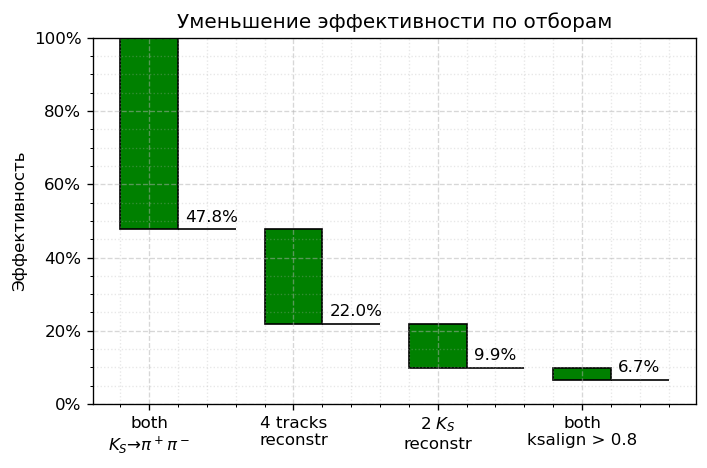

In [29]:
from matplotlib.ticker import PercentFormatter

selections = np.array([1, eff_kppc, eff_4t, eff_2ks, eff_align2])
sel_prod = np.cumprod(selections)

# fig, ax = plt.subplots()
plt.bar(np.arange(4), sel_prod[1:] - sel_prod[:-1], bottom = sel_prod[:-1], 
        color='green', width=0.4, label='1', edgecolor='black');
plt.bar(np.arange(4)+0.4, np.zeros(4), bottom = sel_prod[1:], 
        color='green', width=0.4, label='1', edgecolor='black');
for i, p in enumerate(sel_prod[1:]):
    plt.annotate(f'{p:.1%}', (i + 0.25, p+0.02))
plt.xticks(range(4), ['both\n$K_S \\to \pi^+\pi^-$', '4 tracks\nreconstr', 
                      '2 $K_S$\nreconstr', 'both\nksalign > 0.8'], rotation=0);
plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
pys.my_style('Уменьшение эффективности по отборам',
             ytitle='Эффективность', ylim=(0, 1));

тут также не учтены каты для хороших треков (на ионизационные потери, хи-квадрат треков, z-координату)

______

In [30]:
# tr_mc = uproot.open('/outstage/lukinp/sim/tr_ph_f2ksks_1.8GeV.root')['tr_ph']
hmc = HandlerKSKS(tr_mc)
df_mc = hmc.get_good_kaons()
df_cut_mc = HandlerKSKS.collinear_cut(df_mc)
df_cut_mc = HandlerKSKS.sum_energy_cut(df_cut_mc)
df_cut_mc = HandlerKSKS.kaon_mom_cut(df_cut_mc)
df_cut_mc = HandlerKSKS.flight_cut(df_cut_mc)
df_cut_mc = HandlerKSKS.ksminv_cut(df_cut_mc)

In [31]:
eff_ksks0 = df_mc.index.droplevel(1).nunique()/len(tr_mc.arrays(['nt']))
print(f'Эффективность регистрации KSKS до доп. отборов: {eff_ksks0:.2%}')

Эффективность регистрации KSKS до доп. отборов: 4.76%


In [32]:
eff_ksks = df_cut_mc.index.droplevel(1).nunique()/len(tr_mc.arrays(['nt']))
print(f'Эффективность регистрации KSKS: {eff_ksks:.2%}')

Эффективность регистрации KSKS: 3.59%


## Сравниваю распределения из моделирования эффекта и фона

На картинках показываю **строгие** условия отбора

In [33]:
tr_mc = uproot.open('/outstage/lukinp/sim/tr_ph_f2ksks_1.8GeV.root')['tr_ph']
hmc = HandlerKSKS(tr_mc)
df_mc = hmc.get_good_kaons()

In [34]:
file_mlt = '/store17/petrov/data/kskl20/tr_ph/multi/19/tr_ph_run053321.root'
# file_mlt = '/store17/petrov/data/kskl20/tr_ph/multi/19/tr_ph_run053284.root'
tr_mlt = uproot.open(file_mlt)['tr_ph']
hmlt = HandlerKSKS(tr_mlt)
df_mlt = hmlt.get_good_kaons()

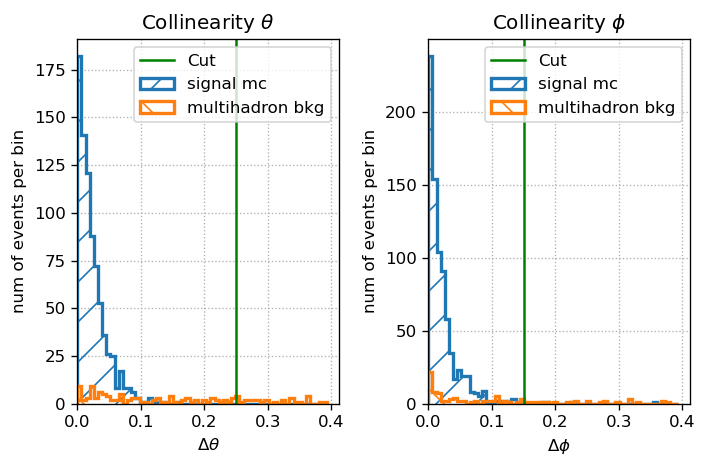

In [35]:
bins, rng, cut_th, cut_ph = 60, (0, np.pi/8), 0.25, 0.15
density = False
dtemp_mc = HandlerKSKS.collinear_cut(df_mc, return_pivot=True)
dtemp_mlt= HandlerKSKS.collinear_cut(df_mlt, return_pivot=True)

fig, ax = plt.subplots(1, 2)
ylabel = 'num of events per bin'
ax[0].hist(dtemp_mc[0], bins=bins, range=rng, label='signal mc',
          histtype='step', density=density, lw=2, hatch='/')
ax[0].hist(dtemp_mlt[0], bins=bins, range=rng, label='multihadron bkg',
          histtype='step', density=density, lw=2, hatch='\\')
ax[0].axvline(x=cut_th, ymin=0, ymax=1, color='green', label='Cut')
ax[0].set(xlim=(0, None), title='Collinearity $\\theta$',
         xlabel='$\\Delta\\theta$', ylabel=ylabel)
ax[1].hist(dtemp_mc[1], bins=bins, range=rng, label='signal mc',
          histtype='step', density=density, lw=2, hatch='/')
ax[1].hist(dtemp_mlt[1], bins=bins, range=rng, label='multihadron bkg',
          histtype='step', density=density, lw=2, hatch='\\')
ax[1].axvline(x=cut_ph, ymin=0, ymax=1, color='green', label='Cut')
ax[1].set(xlim=(0, None), title='Collinearity $\\phi$',
         xlabel='$\\Delta\\phi$', ylabel=ylabel)
for a in ax:
    a.grid(ls=':')
    a.legend()
plt.tight_layout()

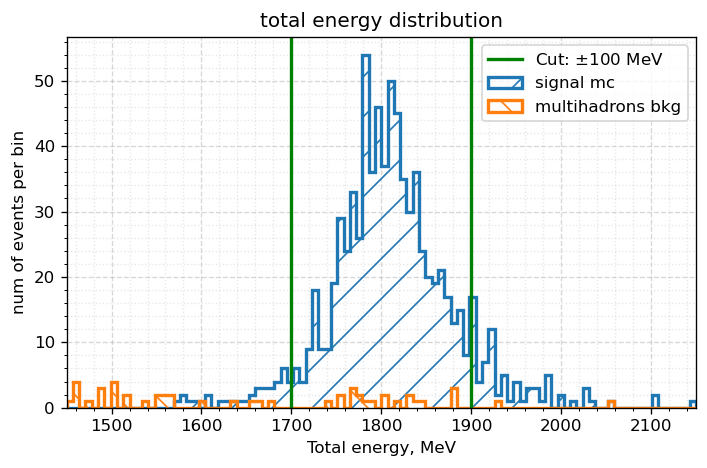

In [36]:
bins, rng, e0, dlt = 100, (df_mc.emeas.mean()*2-350, df_mc.emeas.mean()*2+350), df_mc.emeas.mean()*2, 100
density = False
dtemp_mc = HandlerKSKS.sum_energy_cut(df_mc, return_pivot=True)
dtemp_mlt= HandlerKSKS.sum_energy_cut(df_mlt, return_pivot=True)

plt.hist(dtemp_mc, bins=bins, range=rng, hatch='/',
         label='signal mc', histtype='step', density=density, lw=2);
plt.hist(dtemp_mlt, bins=bins, range=rng, hatch='\\',
         label='multihadrons bkg', histtype='step', density=density, lw=2);
plt.axvline(e0 + dlt, 0, 1, color='green', label='Cut: $\pm 100$ MeV', lw=2)
plt.axvline(e0 - dlt, 0, 1, color='green', lw=2)
pys.my_style('total energy distribution', 'Total energy, MeV', 
             'num of events per bin', xlim=rng, legend=True);

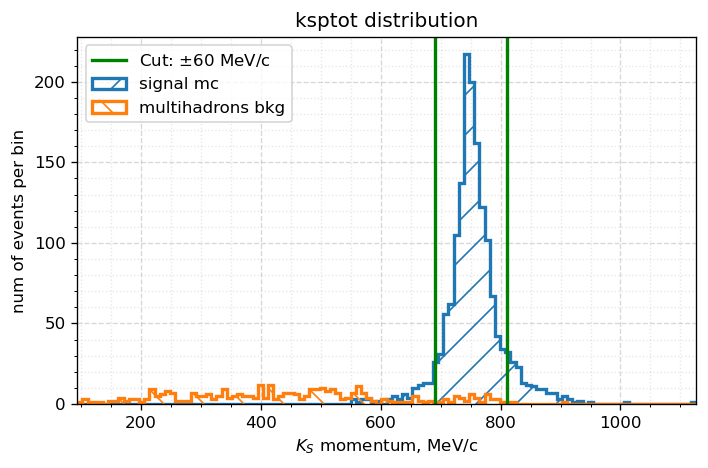

In [37]:
bins, rng = 120, (df_mlt.ksptot.min(), df_mc.ksptot.max())
density = False
plt.hist(df_mc.ksptot, bins=bins, range=rng, hatch='/',
         label='signal mc', histtype='step', density=density, lw=2);
plt.hist(df_mlt.ksptot, bins=bins, range=rng, hatch='\\',
         label='multihadrons bkg', histtype='step', density=density, lw=2);
p0 = np.sqrt(df_mc.emeas.mean()**2 - 497.6**2)
plt.axvline(p0 + 60, 0, 1, color='green', label='Cut: $\pm 60$ MeV/c', lw=2)
plt.axvline(p0 - 60, 0, 1, color='green', lw=2)
pys.my_style('ksptot distribution', '$K_S$ momentum, MeV/c', 
             'num of events per bin', xlim=rng, legend=True);

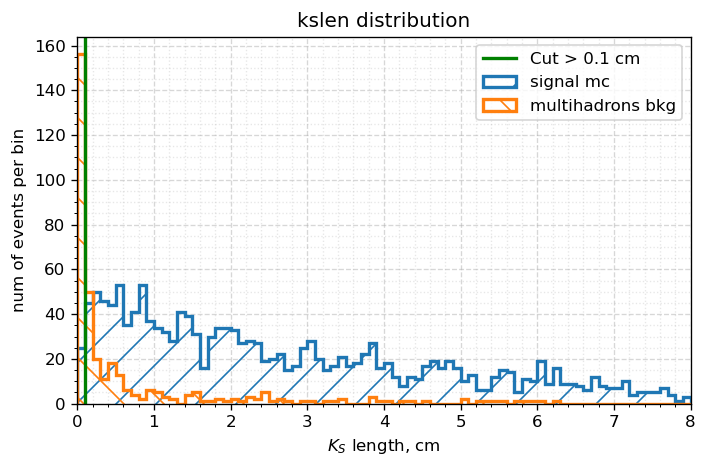

In [38]:
density = False
plt.hist(df_mc.kslen, bins=80, range=(0, 8), hatch='/',
         label='signal mc', histtype='step', density=density, lw=2);
plt.hist(df_mlt.kslen, bins=80, range=(0, 8), hatch='\\',
         label='multihadrons bkg', histtype='step', density=density, lw=2);
plt.axvline(0.1, 0, 1, color='green', label='Cut > 0.1 cm', lw=2)
pys.my_style('kslen distribution', '$K_S$ length, cm', 
             'num of events per bin', xlim=(0, 8), legend=True);

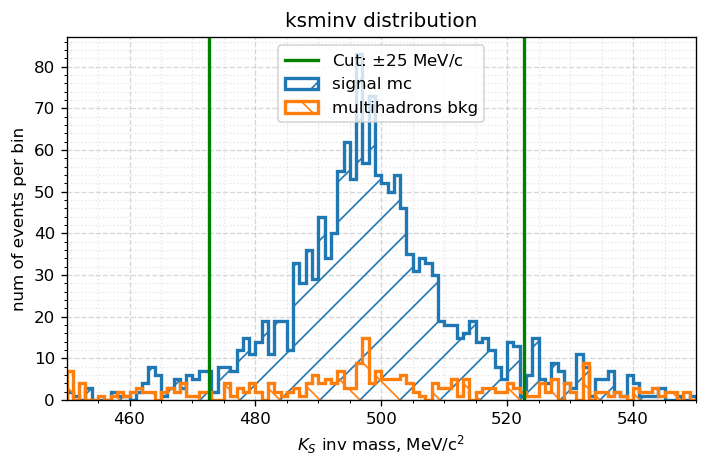

In [39]:
bins, rng, m0, dlt = 100, (450, 550), 497.6, 25
density = False
plt.hist(df_mc.ksminv, bins=bins, range=rng, hatch='/',
         label='signal mc', histtype='step', density=density, lw=2);
plt.hist(df_mlt.ksminv, bins=bins, range=rng, hatch='\\',
         label='multihadrons bkg', histtype='step', density=density, lw=2);
plt.axvline(m0 + dlt, 0, 1, color='green', label='Cut: $\pm 25$ MeV/c', lw=2)
plt.axvline(m0 - dlt, 0, 1, color='green', lw=2)
pys.my_style('ksminv distribution', '$K_S$ inv mass, MeV/c${}^2$', 
             'num of events per bin', xlim=rng, legend=True);

# Processing

Буду постепенно зажимать отборы и при этом смотреть, как согласуется моделирование и эксперимент

Сначала посмотрю, сколько ожидается событий $e^+ e^- \to K_S K_S$ на всей статистике

In [40]:
def season_info(season):
    """
    Получить информацию о сезоне и pd.DataFrame с информацией о точках
    """
    total_info_filename = f'../data/{season}/total_info_{season}.txt'
    total_info = pd.read_csv(total_info_filename, index_col=0)\
        .query('(emeas>545)&(emeas<955)')
    if season=='19':
        total_info = total_info.loc[total_info[['exp_tree', 'elabel', 'mlt_raw']].dropna().index]
    
    n_ksks_expected = \
    (np.interp(total_info['emeas'], df_fksks['ebeam'], df_fksks['cs_vis']) * eff_ksks * total_info['lum_exp']).sum()
    print(f'Season {season}')
    print(f'Energy range: ({total_info.emeas.min():.1f}; {total_info.emeas.max():.1f}) MeV')
    print(f'N(KSKS) expected = {n_ksks_expected:.4f} events')
    print(f'Integrated Lum = {total_info["lum_exp"].sum()*1e-3:.2f} pbn-1\n')
    
    return total_info

In [41]:
total_info = {}

total_info['12'] = season_info('12')
total_info['19'] = season_info('19')

Season 12
Energy range: (638.5; 951.6) MeV
N(KSKS) expected = 0.0112 events
Integrated Lum = 10.47 pbn-1

Season 19
Energy range: (549.3; 951.0) MeV
N(KSKS) expected = 0.0484 events
Integrated Lum = 49.40 pbn-1



Довольно мало событий ожидается 😢

Делаю свободные каты, сравниваю количество событий в эксперименте и моделировании фона

Поиск:
* *4 хороших трека* в событии
* в событии есть *2 каона*, найденных процедурой, причём они составлены из хороших треков
* каоны должны иметь `ksalign > 0.8`
* условие коллинеарности каонов: $f_{coll}(\phi) < 0.4$, $f_{coll}(\theta) < 0.4$
* $| E_{K_1} + E_{K_2} - 2 \cdot E_{beam} | < 250$ МэВ, $E_{K_i}$ - энергия $i$-го каона, МэВ; $E_{beam}$ - энергия пучка, МэВ
* $| P_{K_i} - P_0 | < 120$ МэВ, условие на отличие импульсов каонов ($P_{K_i}$) от идеального по кинематике ($P_0 = \sqrt{E_{beam}^{2} - M_{K}^{2}}$)

In [42]:
from pylib.ksks import preprocess_point, process_point
df_proc = {}

In [43]:
def preprocess_season(total_info, season, force_process, print_log, plot):
    df = pd.DataFrame()
    for i, row in total_info.iterrows():
        dict_row = preprocess_point(row, df_4pic, 
                season=season, force_process=force_process, print_log=print_log)
        df = df.append(dict_row, ignore_index=True)
    if plot:
        plt.errorbar(df.emeas*2e-3, df.n_events, 
                 yerr=df.n_events_err, fmt='.', label='Expected')
        plt.errorbar(df.emeas*2e-3, df.real_events,
                     yerr=np.sqrt(df.real_events), fmt='.', label='Observed')
        pys.my_style('Сравнение ожидаемого фона и наблюдаемое\nколичество событий для слабых отборов', 
                     xtitle='$\sqrt{s}$, GeV', ytitle='num of events',
            legend=True, ylim=(0, None), xlim=(None, None))
    return df

Обработка сезона `12`

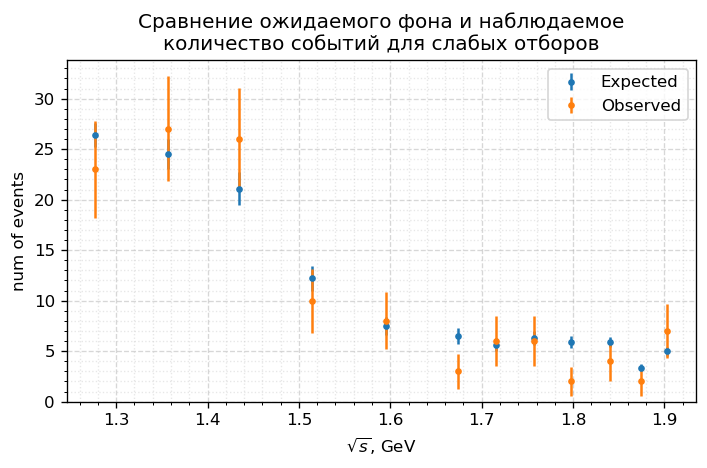

In [44]:
season = '12'
df_proc[season] = preprocess_season(total_info[season], season, False, False, True)

Обработка сезона `19`

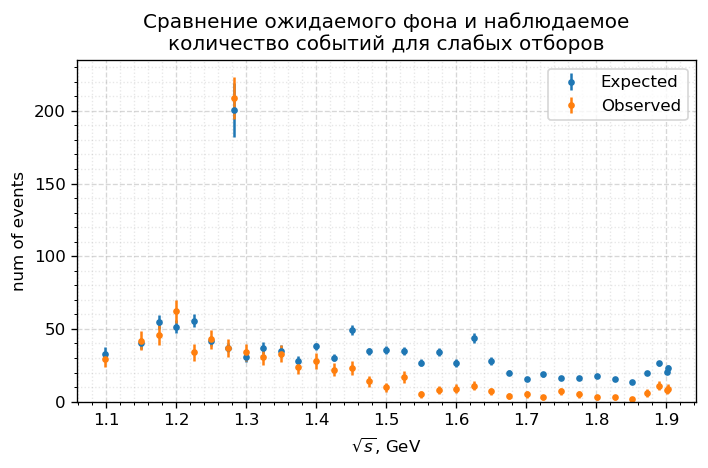

In [45]:
season = '19'
df_proc[season] = preprocess_season(total_info[season], season, False, False, True)

В сезоне `19` ожидаемое количество событий не согласуется с наблюдаемым, причём ожидаемых событий больше, поэтому такую разницу нельзя связать с неучтённым фоновым процессом

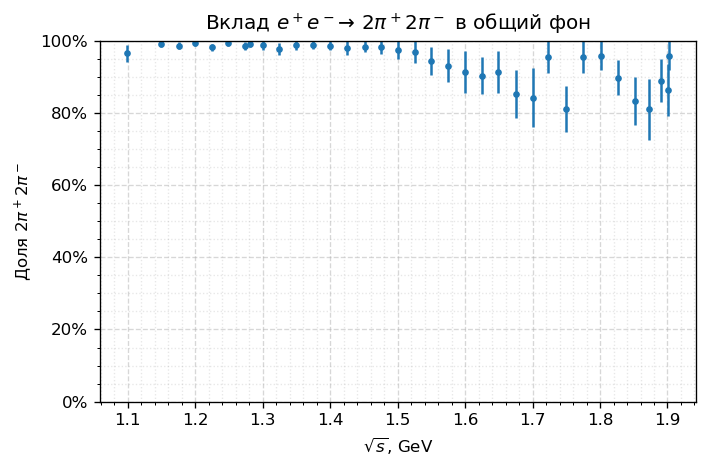

In [46]:
from matplotlib.ticker import PercentFormatter
dtemp = df_proc['19']
plt.errorbar( dtemp.emeas*2e-3, dtemp.part_4pic, 
             yerr=dtemp.part_4pic_err, fmt='.')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) 
pys.my_style('Вклад $e^+e^- \\to \ 2\pi^+2\pi^-$ в общий фон', 
             xtitle='$\sqrt{s}$, GeV',
             ytitle='Доля $2\pi^+2\pi^-$', ylim=(0, 1))

В дальнейшем, для улучшения точности, можно попробовать учесть другие фоновые процессы (хотя веротность, что они выживут в строгих катах, мала)

Усиливаю каты

In [47]:
def process_season(total_info, season, print_log, plot):
    df = pd.DataFrame()
    for i, row in total_info.iterrows():
        dict_row = process_point(row, df_4pic, 
                season=season, print_log=print_log)
        df = df.append(dict_row, ignore_index=True)
    df = df.set_index('elabel')
    df = df.join(total_info[['elabel', 'lum_exp']].set_index('elabel'))
    if plot:
        plt.errorbar(df.emeas*2e-3, df.n_events, 
                 yerr=df.n_events_err, fmt='.', label='Expected')
        plt.errorbar(df.emeas*2e-3, df.real_events,
                     yerr=np.sqrt(df.real_events), fmt='.', label='Observed')
        pys.my_style('Сравнение ожидаемого фона и наблюдаемое\nколичество событий', 
                     xtitle='$\sqrt{s}$, GeV', ytitle='num of events',
            legend=True, ylim=(0, None), xlim=(None, None))
    return df

In [48]:
df_events = pd.DataFrame()
df_events = df_events.append(process_season(total_info['12'], '12', False, False))
df_events = df_events.append(process_season(total_info['19'], '19', False, False))

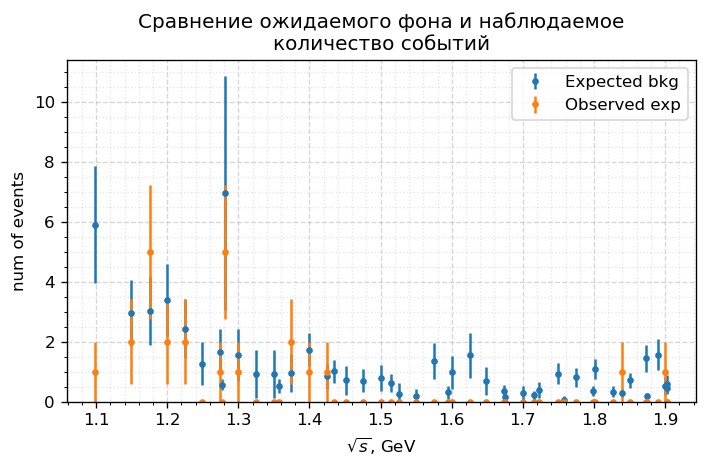

In [49]:
plt.errorbar(df_events.emeas*2e-3, df_events.n_events,
            yerr=df_events.n_events_err, fmt='.', label='Expected bkg')
plt.errorbar(df_events.emeas*2e-3, df_events.real_events,
            yerr=np.sqrt(df_events.real_events), fmt='.', label='Observed exp')
pys.my_style('Сравнение ожидаемого фона и наблюдаемое\nколичество событий', 
             xtitle='$\sqrt{s}$, GeV', ytitle='num of events',
    legend=True, ylim=(0, None), xlim=(None, None))

Добавляю поле с ожидаемым количеством сигнала (`n_sig`) в унитарном пределе в `df_events`. 

In [58]:
df_events['cs_born'] = born_ee_f((df_events.emeas*2e-3)**2)
df_events['cs_vis'] = born2visible(df_events['emeas'], 
                                   df_events['cs_born'], threshold=497.6)
df_events['n_sig'] = df_events['cs_vis'] * df_events['lum_exp'] * eff_ksks/2 #/2 ? (из-за того, что K antiK может быть как KSKS, так и KLKL)

Строю лайклихуд и с помощью `minuit` вычисляю интервал

In [59]:
from scipy.stats import poisson
from scipy.stats import norm

In [60]:
def cost_function(Br=[0] + [0]*len(df_events)):
    """
    Лайклихуд
    """
    nb = np.array(Br[1:])
    eff = (df_events.n_events_err**2)/df_events.n_events
    f = -np.sum(
        np.log(
            poisson.pmf(df_events.real_events, df_events.n_sig*Br[0] + nb)
        )
        +np.log(
            norm.pdf(df_events.n_events, nb, np.sqrt(eff*nb))
        )
    )
    return f

In [61]:
a = [1] + df_events.n_events.tolist()

In [62]:
m = iminuit.minuit.Minuit(cost_function, np.array(a))
m.errordef = iminuit.minuit.Minuit.LIKELIHOOD
for i in range(len(a)):
    m.limits[f'x{i}'] = (0, None)

In [63]:
m.simplex().migrad()#.minos(cl=0.9);
m.valid

True

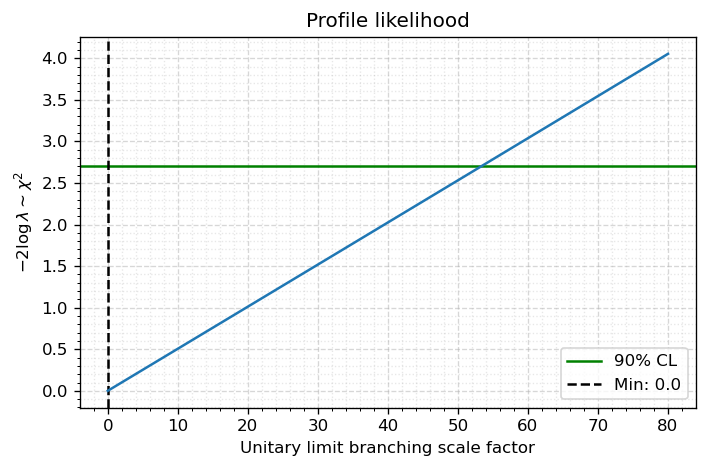

In [64]:
tx, ty, _ = m.mnprofile('x0', bound=(1e-6, 80), subtract_min=True)
ty*=2
plt.axhline(2.706, 0, 1, c='g', label='90% CL')
plt.axvline(tx[np.argmin(ty)], 0, 1, c='black', ls='--', 
            label=f'Min: {tx[np.argmin(ty)]:.1f}')
plt.plot(tx, ty);
pys.my_style('Profile likelihood', 'Unitary limit branching scale factor', 
             '$-2\log{\lambda} \sim \chi^2$', legend=True);

На картинке показан *profile likelihood*. По оси `x` показан фитируемый параметр - масштаб, т.е. во сколько раз наблюдаемое количество событий сигнала больше ожидаемого в унитарном пределе.

Т.к. *profile likelihood* ~ $\chi^2(1)$, то интервал доверия 90% соответствует значению 2.703

Перевожу масштабный параметр в бранчинг, показываю результат:

In [65]:
cl90 = np.interp(2.706, ty, tx)
print(f'Br < {(cl90*Br_ee_unitary_limit):.2e} at 90% CL')

Br < 1.20e-09 at 90% CL


# Источники

1. [$f_2^{'}(1525)$ PDG](https://pdglive.lbl.gov/Particle.action?init=0&node=M013&home=MXXX005)

## Статьи

1. [BaBar, $e^+e^- \to \pi^+\pi^-\pi^+\pi^-$](https://arxiv.org/pdf/1201.5677.pdf)
1. [Limits and Confidence Intervals in the Presence of Nuisance Parameters](https://arxiv.org/pdf/physics/0403059.pdf)
1. [A Unified Approach to the Classical Statistical Analysis of Small Signals](https://arxiv.org/pdf/physics/9711021.pdf)